In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

from zipfile import ZipFile
! cp '/content/drive/MyDrive/ML_Capstone/drive-download.zip' '/content'
from zipfile import ZipFile
zip = ZipFile('/content/drive-download.zip')
zip.extractall()

Mounted at /content/drive/


In [ ]:
# importing required packages
import os
import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision

# Dataset and Dataloaders

In [ ]:
# Set device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Lazy Loading

data
-train
  - X
    - 1
      - rgb
        - 0.png
        - 1.png
        - 2.png
      - depth.npy
      - field_id.pkl
    
    - 2

    - ...
  - Y
    - 1.npy
    - 2.npy

-test

In [ ]:
class LazyLoadDataset(Dataset):
  def __init__(self,path,train=True,transform=None):
    self.train = train
    self.transform = transform
    path = path + ("train/" if self.train else "test/")

    self.pathX = path + "X/"
    self.pathY = path + "Y/"

    self.data = os.listdir(self.pathX)

  def __getitem__(self,idx):
    f = self.data[idx]

    # X
    # read rgb images
    #img0 = cv2.imread(self.pathX + f + "/rgb/0.png")/255

    # read depth images
    depth = np.load(self.pathX + f + "/depth.npy")/1000
    depth = depth.transpose((1,2,0))
        
    if self.transform is not None:
      depth = self.transform(depth)

    # read field ID
    field_id = pkl.load(open(self.pathX + f + "/field_id.pkl","rb"))

    if self.train==True:
      # Y 
      Y = np.load(self.pathY + f + ".npy")*1000
      return (depth.float().type(torch.float32),field_id),torch.from_numpy(Y).float().type(torch.float32)

    else: # if test, there is no Y
      return depth.float().type(torch.float32),field_id

  def __len__(self):
    return len(self.data)


# Normalization: Compute Mean and Std



In [ ]:
train_dataset_raw = LazyLoadDataset("/content/",train=True,transform=ToTensor()) 
means=[]
stds=[]
for i in range(3396):
  (depth_i, id_i),Y_i=train_dataset_raw[i]
  means.append([torch.mean(depth_i[0]).item(),torch.mean(depth_i[1]).item(),torch.mean(depth_i[2]).item()])
  stds.append([torch.std(depth_i[0]).item(),torch.std(depth_i[1]).item(),torch.std(depth_i[2]).item()])

In [ ]:
depth_i.shape

torch.Size([3, 224, 224])

In [ ]:
means

In [ ]:
norm_mean=np.mean(means,axis =0)
norm_mean = list(norm_mean)
norm_mean

[0.6557701463834136, 0.8711379854923423, 1.2105857684804637]

In [ ]:
norm_std=np.mean(stds,axis=0)
norm_std = list(norm_std)
norm_std

[0.40322135255460323, 0.6190313919062328, 1.0969438298185246]

# Train Dataset & Train loader

In [ ]:
#transform=transforms.Compose([transforms.ToTensor()])
train_dataset = LazyLoadDataset("/content/",transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),])) 

In [ ]:
train_dataset[0]

In [ ]:
(depth0, field_id), Y = train_dataset[0]

In [ ]:
batch_size_train = 4
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)

torch.Size([4, 3, 224, 224])


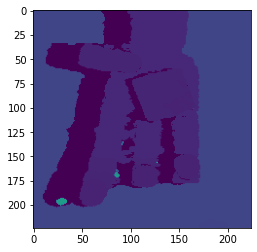

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  #print(data) #plot the channel 3 of img0 in one batch
  print(data[0].shape)
  plt.imshow(data[0][0][0])
  #plt.show()
  #plt.imshow(data[0])
  break

# Test Dataset & Test loader

In [ ]:
test_dataset = LazyLoadDataset("/content/",train=False,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),
                   ])) #,transform=transform

batch_size_test = 2
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

# Model

In [ ]:
class Res(nn.Module):
    def __init__(self, input_channels,output_size):
        super(Res, self).__init__()
        
        # We use Sequential for simplicity
        self.stack = nn.Sequential(models.resnet50(pretrained=True),
                                   nn.Linear(1000, output_size))
                                 
    def forward(self, x):
        x = self.stack(x)
        return x

In [ ]:
# Model input/output settings
input_channels = 3 # number of input channels
output_size=12

In [ ]:
def train(epoch, model, optimizer,loader=train_loader):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        loader: val/train loader
    """
    model.train()
    for batch_idx,((data, id),target) in enumerate(loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(len(id),3,224, 224)

        # consider passing different data augmentation in training
        # data = F.invert()
        # data = F.adjust_sharpness(data,sharpness_factor = 0.5)
        # data = F.adjust_hue(data,hue_factor = 0.9)
        # data = F.adjust_saturation(data,saturation_factor = 0.5)

        # make sure we erase all the gradients before computing new ones
        optimizer.zero_grad() 
        
        # forward propagation
        output = model(data)

        #RMSE loss
        loss = torch.sqrt(nn.functional.mse_loss(output,target))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss))
            

In [ ]:
def test(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    ids = []
    preds = []
    with torch.no_grad():
      for batch_idx,(data, id) in enumerate(test_loader):
        # send to device
        data = data.to(device)          
        pred = model(data)
        for i in range(len(id)):
          ids.append(id[i])
          preds.append(np.array(pred[i].cpu()/1000,dtype="float64"))

    return ids, preds  
    

In [ ]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cross-Validation & Grid-Search for determining hyperparameters

What should hyperparameters in the models be? We could perform grid-search on the whole train dataset and pick the best-performing hyerparameters. But to avoid over-fitting on the train dataset, we split the whole train dataset into 9:1.
*   cross_val_train_set (90% of train dataset)
*   cross_val_test_set (10% of train dataset)

We train our model on the cross_val_train_set and test our model on cross_val_test_set. We pick the best-performing hyperparameters on the cross_val_test_set.

After all these steps, we train our model using the picked hyperparameters on the whole train dataset. 

In [ ]:
cross_val_train_set, cross_val_test_set = train_test_split(train_dataset, test_size=0.1)

In [ ]:
# Sanity Check
len(cross_val_train_set) == int(len(train_dataset)*0.9)
len(cross_val_train_set)

3056

In [ ]:
batch_size_cross_val_train = 4
batch_size_cross_val_test = len(cross_val_test_set) # = 340
len(cross_val_test_set)

340

In [ ]:
cross_val_train_loader=DataLoader(cross_val_train_set,batch_size=batch_size_cross_val_train,shuffle=True)
cross_val_test_loader=DataLoader(cross_val_test_set,batch_size=batch_size_cross_val_test,shuffle=True)

In [ ]:
len(cross_val_test_loader)

1

In [ ]:
def cross_val(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    # We can just edit on the code for train(). We should delete the bakward propagation part and optimizer part.

    with torch.no_grad():
      for batch_idx,((data, id),target) in enumerate(cross_val_test_loader):
          # send to device
          if batch_idx==0:
            data, target = data.to(device), target.to(device)
            
            # forward propagation
            output = model(data)

            #RMSE loss
            loss = torch.sqrt(nn.functional.mse_loss(output,target))
            return loss.item()

In [ ]:
def SGD_hyper_tuning(lr_list,momentum_list):  
  for j in momentum_list:
    for i in lr_list:
      model_res = Res(input_channels, output_size) # create Res model
      model_res.to(device)
      print("lr=",i,"momentum=",j)
      train(epoch=0, model=model_res, optimizer=torch.optim.SGD(model_res.parameters(), lr=i,momentum=j),loader=cross_val_train_loader)
      print("Validation Performance:",cross_val(model_res))

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 1e-05 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.683670
Train Epoch: 0 [800/3056 (26%)]	Loss: 60.164169
Train Epoch: 0 [1600/3056 (52%)]	Loss: 33.303402
Train Epoch: 0 [2400/3056 (79%)]	Loss: 21.375429
Validation Performance: 14.919356346130371
lr= 0.0001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 62.530960
Train Epoch: 0 [800/3056 (26%)]	Loss: 16.776390
Train Epoch: 0 [1600/3056 (52%)]	Loss: 10.272785
Train Epoch: 0 [2400/3056 (79%)]	Loss: 15.428633
Validation Performance: 8.638474464416504
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 69.295792
Train Epoch: 0 [800/3056 (26%)]	Loss: 14.332638
Train Epoch: 0 [1600/3056 (52%)]	Loss: 16.115334
Train Epoch: 0 [2400/3056 (79%)]	Loss: 13.544391
Validation Performance: 12.351624488830566
lr= 0.01 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.428490
Train Epoch: 0 [800/3056 (26%)]	Loss: 17.710760
Train Epoch: 0 [1600/3056 (52%)]	Loss: 15.718327
Train Epoch: 0 [2400/3056 (79%)]	Loss: 18.679117
Validati

Top 3 Performance (Results may vary if rerun the program)
1.  lr = 1e-3, momentum = 0.91
2.  lr = 1e-3, momentum = 0.93
3.  lr = 1e-4, momentum = 0.95

In [ ]:
lr_list = [8e-4,9e-4,1e-3,2e-3,3e-3]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 0.0008 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 69.712311
Train Epoch: 0 [800/3056 (26%)]	Loss: 17.946781
Train Epoch: 0 [1600/3056 (52%)]	Loss: 15.049610
Train Epoch: 0 [2400/3056 (79%)]	Loss: 12.540418
Validation Performance: 13.86676025390625
lr= 0.0009 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 64.437958
Train Epoch: 0 [800/3056 (26%)]	Loss: 18.381628
Train Epoch: 0 [1600/3056 (52%)]	Loss: 13.775934
Train Epoch: 0 [2400/3056 (79%)]	Loss: 11.428717
Validation Performance: 13.92055606842041
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.068542
Train Epoch: 0 [800/3056 (26%)]	Loss: 15.279761
Train Epoch: 0 [1600/3056 (52%)]	Loss: 12.929020
Train Epoch: 0 [2400/3056 (79%)]	Loss: 8.776793
Validation Performance: 14.074189186096191
lr= 0.002 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 67.830933
Train Epoch: 0 [800/3056 (26%)]	Loss: 27.850080
Train Epoch: 0 [1600/3056 (52%)]	Loss: 23.020533
Train Epoch: 0 [2400/3056 (79%)]	Loss: 11.427743
Validati

Top 2 Performance (Results may vary if rerun the program)

1.   lr = 1e-3, momentum = 0.91
2.   lr = 9e-4, momentum = 0.91


# lr=1e-3, momentum=0.91, 20 epoch, train_batch_size = 4, no lr decay

In [ ]:
model_res = Res(input_channels, output_size) # create Res model
model_res.to(device)
optimizer = torch.optim.SGD(model_res.parameters(), lr=1e-3,momentum=0.91) 

print("lr=",1e-3,"momentum=",0.91)
for epoch in range(20):
  train(epoch, model=model_res, optimizer=torch.optim.SGD(model_res.parameters(), lr=1e-3,momentum=0.91),loader=train_loader)


lr= 0.001 momentum= 0.91
Train Epoch: 0 [0/3396 (0%)]	Loss: 64.378502
Train Epoch: 0 [800/3396 (24%)]	Loss: 12.237373
Train Epoch: 0 [1600/3396 (47%)]	Loss: 10.411184
Train Epoch: 0 [2400/3396 (71%)]	Loss: 7.609773
Train Epoch: 0 [3200/3396 (94%)]	Loss: 7.007903
Train Epoch: 1 [0/3396 (0%)]	Loss: 7.773539
Train Epoch: 1 [800/3396 (24%)]	Loss: 6.003336
Train Epoch: 1 [1600/3396 (47%)]	Loss: 7.873209
Train Epoch: 1 [2400/3396 (71%)]	Loss: 10.546397
Train Epoch: 1 [3200/3396 (94%)]	Loss: 5.416355
Train Epoch: 2 [0/3396 (0%)]	Loss: 5.598324
Train Epoch: 2 [800/3396 (24%)]	Loss: 3.449342
Train Epoch: 2 [1600/3396 (47%)]	Loss: 3.788028
Train Epoch: 2 [2400/3396 (71%)]	Loss: 4.275848
Train Epoch: 2 [3200/3396 (94%)]	Loss: 4.462946
Train Epoch: 3 [0/3396 (0%)]	Loss: 4.308082
Train Epoch: 3 [800/3396 (24%)]	Loss: 3.708862
Train Epoch: 3 [1600/3396 (47%)]	Loss: 4.415435
Train Epoch: 3 [2400/3396 (71%)]	Loss: 4.514237
Train Epoch: 3 [3200/3396 (94%)]	Loss: 4.081860
Train Epoch: 4 [0/3396 (0%)]	Lo

In [ ]:
torch.save(model_res,'/content/drive/MyDrive/ML_Capstone/v5_res_3depth_m1.pt')
model_res = torch.load('/content/drive/MyDrive/ML_Capstone/v5_res_3depth_m1.pt')
model_res.eval()
ids,preds = test(model_res)

outfile = '/content/drive/MyDrive/ML_Capstone/submission_v5_res_3depth_m1.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

df = pd.concat([pd.DataFrame(ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file /content/drive/MyDrive/ML_Capstone/submission_v5_res_3depth_m1.csv


# lr=9e-4, momentum=0.91, 20 epoch, train_batch_size = 4, no lr decay

In [ ]:
model_res = Res(input_channels, output_size) # create Res model
model_res.to(device)
optimizer = torch.optim.SGD(model_res.parameters(), lr=9e-4,momentum=0.91) 

print("lr=",9e-4,"momentum=",0.91)
for epoch in range(20):
  train(epoch, model=model_res, optimizer=torch.optim.SGD(model_res.parameters(), lr=9e-4,momentum=0.91),loader=train_loader)


lr= 0.0009 momentum= 0.91
Train Epoch: 0 [0/3396 (0%)]	Loss: 64.965042
Train Epoch: 0 [800/3396 (24%)]	Loss: 12.882287
Train Epoch: 0 [1600/3396 (47%)]	Loss: 12.474922
Train Epoch: 0 [2400/3396 (71%)]	Loss: 8.325375
Train Epoch: 0 [3200/3396 (94%)]	Loss: 6.702332
Train Epoch: 1 [0/3396 (0%)]	Loss: 7.607909
Train Epoch: 1 [800/3396 (24%)]	Loss: 7.073873
Train Epoch: 1 [1600/3396 (47%)]	Loss: 5.684043
Train Epoch: 1 [2400/3396 (71%)]	Loss: 6.656573
Train Epoch: 1 [3200/3396 (94%)]	Loss: 3.288229
Train Epoch: 2 [0/3396 (0%)]	Loss: 5.204826
Train Epoch: 2 [800/3396 (24%)]	Loss: 4.785174
Train Epoch: 2 [1600/3396 (47%)]	Loss: 5.389794
Train Epoch: 2 [2400/3396 (71%)]	Loss: 4.501188
Train Epoch: 2 [3200/3396 (94%)]	Loss: 5.986868
Train Epoch: 3 [0/3396 (0%)]	Loss: 4.825743
Train Epoch: 3 [800/3396 (24%)]	Loss: 3.667217
Train Epoch: 3 [1600/3396 (47%)]	Loss: 6.039679
Train Epoch: 3 [2400/3396 (71%)]	Loss: 3.614873
Train Epoch: 3 [3200/3396 (94%)]	Loss: 4.248601
Train Epoch: 4 [0/3396 (0%)]	Lo

In [ ]:
torch.save(model_res,'/content/drive/MyDrive/ML_Capstone/v5_res_3depth_m2.pt')
model_res = torch.load('/content/drive/MyDrive/ML_Capstone/v5_res_3depth_m2.pt')
model_res.eval()
ids,preds = test(model_res)

outfile = '/content/drive/MyDrive/ML_Capstone/submission_v5_res_3depth_m2.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

df = pd.concat([pd.DataFrame(ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file /content/drive/MyDrive/ML_Capstone/submission_v5_res_3depth_m2.csv


It's worth notice that: based on Kaggle results, lr=9e-4, momentum=0.91, 20 epoch, train_batch_size = 4, no lr decay performs better. This suggests that we don't just try top performing parameters on validation set. Maybe trying top 2 or 3 would be a good choice.